In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [35]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# 1. Data Generation (Burgers' Equation)
# ==========================================


def generate_burgers_data(n_boundary, n_domain):
    """
    Generates collocation points for Burgers' equation.
    Domain: x in [0, 1], t in [0, 1]
    """
    # --- Boundary Conditions (BC) + Initial Condition (IC) ---
    # Side 1: x=0, for any t
    t_bc1 = np.random.uniform(0, 1, (n_boundary // 3, 1))
    x_bc1 = np.zeros((n_boundary // 3, 1))
    u_bc1 = np.zeros((n_boundary // 3, 1))

    # Side 2: x=1, for any t
    t_bc2 = np.random.uniform(0, 1, (n_boundary // 3, 1))
    x_bc2 = np.ones((n_boundary // 3, 1))
    u_bc2 = np.zeros((n_boundary // 3, 1))

    # Initial Condition: t=0, for any x
    x_ic = np.random.uniform(0, 1, (n_boundary // 3, 1))
    t_ic = np.zeros((n_boundary // 3, 1))
    # Standard IC: -sin(pi*x)
    u_ic = -np.sin(np.pi * x_ic)

    # Combine all boundary points
    X_boundary = np.vstack([x_bc1, x_bc2, x_ic])
    T_boundary = np.vstack([t_bc1, t_bc2, t_ic])
    Y_boundary = np.vstack([u_bc1, u_bc2, u_ic])

    # --- Domain Points (Collocation points for PDE) ---
    x_dom = np.random.uniform(0, 1, (n_domain, 1))
    t_dom = np.random.uniform(0, 1, (n_domain, 1))

    # Convert to Tensors
    # BC Inputs: [x, t]
    inputs_bc = torch.tensor(np.hstack([X_boundary, T_boundary]), dtype=torch.float32)
    targets_bc = torch.tensor(Y_boundary, dtype=torch.float32)

    # PDE Inputs: [x, t] (Requires Gradient for physics derivatives)
    inputs_pde = torch.tensor(
        np.hstack([x_dom, t_dom]), dtype=torch.float32, requires_grad=True
    )

    return inputs_bc, targets_bc, inputs_pde


In [36]:
# ==========================================
# 2. Model Definition
# ==========================================


class BurgersPINN(nn.Module):
    def __init__(self, layers=[2, 20, 20, 20, 20, 1]):
        super().__init__()
        self.depth = len(layers) - 1
        activation = nn.Tanh

        layer_list = []
        for i in range(self.depth - 1):
            layer_list.append(nn.Linear(layers[i], layers[i + 1]))
            layer_list.append(activation())
        # Last layer (linear output)
        layer_list.append(nn.Linear(layers[-2], layers[-1]))

        self.net = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.net(x)


def calculate_physics_residual(model, inputs_pde):
    """
    Calculates the residual for Burgers' equation:
    f = u_t + u * u_x - (0.01/pi) * u_xx
    """

    # Forward pass
    u = model(inputs_pde)

    # Automatic Differentiation
    grads = torch.autograd.grad(
        u, inputs_pde, grad_outputs=torch.ones_like(u), create_graph=True
    )[0]

    u_x = grads[:, 0:1]
    u_t = grads[:, 1:2]

    # Second derivative w.r.t x
    u_xx = torch.autograd.grad(
        u_x, inputs_pde, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0][:, 0:1]

    # Burgers' equation physics parameters (Viscosity nu = 0.01/pi)
    nu = 0.01 / np.pi

    # Residual f should be 0
    f_residual = u_t + (u * u_x) - (nu * u_xx)

    return f_residual


In [ ]:
# ==========================================
# 3. Standard Training (Fixed Weights)
# ==========================================


def train_standard(
    model, inputs_bc, targets_bc, inputs_pde, alpha, epochs=2000, lr=1e-3
):
    print("\n--- Starting Standard Training (Fixed Weights) ---")
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    history = {"loss": [], "loss_bc": [], "loss_pde": []}

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # 1. Boundary Loss
        u_pred_bc = model(inputs_bc)
        loss_bc = loss_fn(u_pred_bc, targets_bc)

        # 2. Physics Loss (Residual)
        f_pred = calculate_physics_residual(model, inputs_pde)
        loss_pde = torch.mean(f_pred**2)

        loss = alpha * loss_bc + (1 - alpha) * loss_pde

        loss.backward()
        optimizer.step()

        # Logging
        history["loss"].append(loss.item())
        history["loss_bc"].append(loss_bc.item())
        history["loss_pde"].append(loss_pde.item())

        if epoch % 500 == 0:
            print(
                f"Epoch {epoch}: Total Loss: {loss.item():.5f} (BC: {loss_bc.item():.5f}, PDE: {loss_pde.item():.5f})"
            )

    return history


In [38]:
# ==========================================
# 4. Self-Adaptive Training (Uncertainty Weighting)
# ==========================================


def train_adaptive_pinn(
    model,
    inputs_bc,
    targets_bc,
    inputs_pde,
    epochs=2000,
    lr_model=1e-3,
    lr_weights=1e-3,
):
    """
    Trains the PINN by automatically adjusting weights between L_bc and L_pde
    using homoscedastic uncertainty (log-variances s_bc, s_pde).
    """
    print("\n--- Starting Adaptive Training (Dynamic Weights) ---")
    device = inputs_bc.device
    model.to(device)
    model.train()

    # Optimizer for the Neural Network
    optimizer_model = optim.Adam(model.parameters(), lr=lr_model)

    # Adaptive Parameters (s = log(sigma^2))
    # We initialize them at 0.0 (sigma=1)
    s_bc = torch.tensor(0.0, requires_grad=True, device=device)
    s_pde = torch.tensor(0.0, requires_grad=True, device=device)

    # Optimizer for the Loss Weights
    optimizer_w = optim.Adam([s_bc, s_pde], lr=lr_weights)

    loss_fn_bc = nn.MSELoss()

    history = {
        "loss_total": [],
        "loss_bc": [],
        "loss_pde": [],
        "s_bc": [],
        "s_pde": [],
        "w_bc": [],  # Effective weight for BC
        "w_pde": [],  # Effective weight for PDE
    }

    for epoch in range(epochs):
        optimizer_model.zero_grad()
        optimizer_w.zero_grad()

        # 1. Calculate Raw Losses
        u_pred_bc = model(inputs_bc)
        loss_bc_val = loss_fn_bc(u_pred_bc, targets_bc)

        f_pred = calculate_physics_residual(model, inputs_pde)
        loss_pde_val = torch.mean(f_pred**2)

        # 2. Adaptive Loss Function (Kendall & Gal)
        # Loss = exp(-s1)*L1 + exp(-s2)*L2 + s1 + s2
        # The terms (+ s_bc + s_pde) act as regularizers to prevent s from going to infinity.

        loss = (
            torch.exp(-s_bc) * loss_bc_val
            + torch.exp(-s_pde) * loss_pde_val
            + s_bc
            + s_pde
        )

        loss.backward()
        optimizer_model.step()
        optimizer_w.step()

        # Logging
        history["loss_total"].append(loss.item())
        history["loss_bc"].append(loss_bc_val.item())
        history["loss_pde"].append(loss_pde_val.item())
        history["s_bc"].append(s_bc.detach().item())
        history["s_pde"].append(s_pde.detach().item())

        # Effective weight is exp(-s)
        history["w_bc"].append(torch.exp(-s_bc).detach().item())
        history["w_pde"].append(torch.exp(-s_pde).detach().item())

        if epoch % 500 == 0:
            print(
                f"Epoch {epoch}: Loss: {loss.item():.4f} | "
                f"L_BC: {loss_bc_val.item():.4f} (w={history['w_bc'][-1]:.2f}) | "
                f"L_PDE: {loss_pde_val.item():.4f} (w={history['w_pde'][-1]:.2f})"
            )

    return history


In [39]:
# ==========================================
# 5. Execution
# ==========================================

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Generate Data
inputs_bc, targets_bc, inputs_pde = generate_burgers_data(n_boundary=600, n_domain=2000)

# Move to Device
inputs_bc = inputs_bc.to(device)
targets_bc = targets_bc.to(device)
inputs_pde = inputs_pde.to(device)

# --- Model 1: Standard Training ---
pinn_std = BurgersPINN().to(device)
hist_std = train_standard(
    pinn_std, inputs_bc, targets_bc, inputs_pde, alpha=1e-2, epochs=20000
)

# --- Model 2: Adaptive Training ---
pinn_adapt = BurgersPINN().to(device)
hist_adapt = train_adaptive_pinn(
    pinn_adapt, inputs_bc, targets_bc, inputs_pde, epochs=20000
)


Using device: cuda

--- Starting Standard Training (Fixed Weights) ---
Epoch 0: Total Loss: 0.11750 (BC: 0.11868, PDE: 0.00034)
Epoch 500: Total Loss: 0.00447 (BC: 0.00080, PDE: 0.36763)
Epoch 1000: Total Loss: 0.00384 (BC: 0.00050, PDE: 0.33457)
Epoch 1500: Total Loss: 0.00362 (BC: 0.00045, PDE: 0.31732)
Epoch 2000: Total Loss: 0.00347 (BC: 0.00042, PDE: 0.30589)
Epoch 2500: Total Loss: 0.00334 (BC: 0.00038, PDE: 0.29675)
Epoch 3000: Total Loss: 0.00331 (BC: 0.00055, PDE: 0.27708)
Epoch 3500: Total Loss: 0.00306 (BC: 0.00029, PDE: 0.27691)
Epoch 4000: Total Loss: 0.00291 (BC: 0.00024, PDE: 0.26697)
Epoch 4500: Total Loss: 0.00278 (BC: 0.00022, PDE: 0.25614)
Epoch 5000: Total Loss: 0.00268 (BC: 0.00019, PDE: 0.24910)
Epoch 5500: Total Loss: 0.00256 (BC: 0.00019, PDE: 0.23805)
Epoch 6000: Total Loss: 0.00245 (BC: 0.00017, PDE: 0.22881)
Epoch 6500: Total Loss: 0.00236 (BC: 0.00016, PDE: 0.21993)
Epoch 7000: Total Loss: 0.00227 (BC: 0.00015, PDE: 0.21173)
Epoch 7500: Total Loss: 0.00218 (

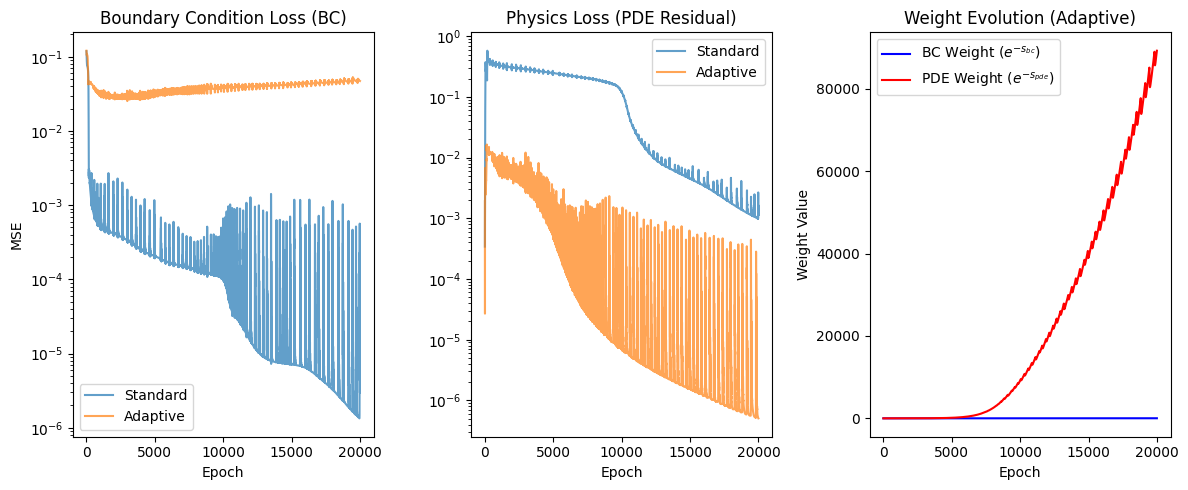

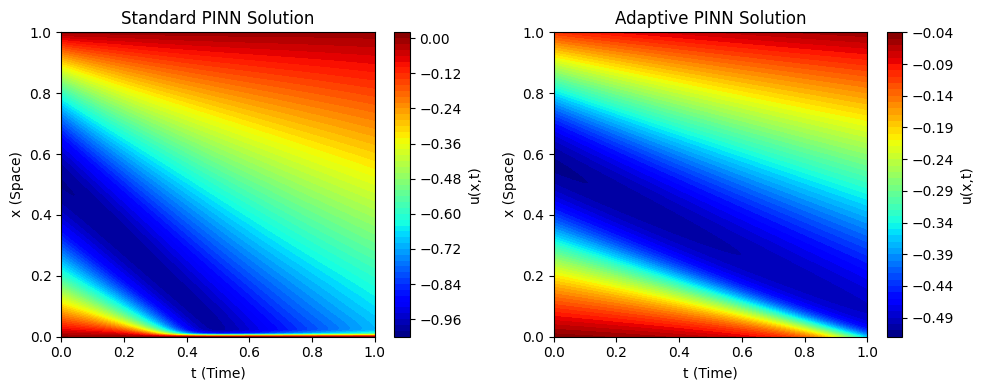

In [40]:
# ==========================================
# 6. Visualization & Comparison
# ==========================================

# A. Loss Curves
plt.figure(figsize=(12, 5))

# Plot 1: Standard vs Adaptive (BC Loss)
plt.subplot(1, 3, 1)
plt.plot(hist_std["loss_bc"], label="Standard", alpha=0.7)
plt.plot(hist_adapt["loss_bc"], label="Adaptive", alpha=0.7)
plt.yscale("log")
plt.title("Boundary Condition Loss (BC)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

# Plot 2: Standard vs Adaptive (PDE Loss)
plt.subplot(1, 3, 2)
plt.plot(hist_std["loss_pde"], label="Standard", alpha=0.7)
plt.plot(hist_adapt["loss_pde"], label="Adaptive", alpha=0.7)
plt.yscale("log")
plt.title("Physics Loss (PDE Residual)")
plt.xlabel("Epoch")
plt.legend()

# Plot 3: Adaptive Weights Evolution
plt.subplot(1, 3, 3)
plt.plot(hist_adapt["w_bc"], label=r"BC Weight ($e^{-s_{bc}}$)", color="blue")
plt.plot(hist_adapt["w_pde"], label=r"PDE Weight ($e^{-s_{pde}}$)", color="red")
plt.title("Weight Evolution (Adaptive)")
plt.xlabel("Epoch")
plt.ylabel("Weight Value")
plt.legend()

plt.tight_layout()
plt.show()


# B. Solution Visualization (Contour Plot)
def plot_solution(model, title):
    # Create a grid for visualization
    x = np.linspace(0, 1, 100)
    t = np.linspace(0, 1, 100)
    t_grid, x_grid = np.meshgrid(t, x)

    # Flatten and combine for model input
    X_test = np.hstack((x_grid.flatten()[:, None], t_grid.flatten()[:, None]))
    X_test_tens = torch.tensor(X_test, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        u_pred = model(X_test_tens).cpu().numpy().reshape(x_grid.shape)

    plt.contourf(t_grid, x_grid, u_pred, levels=50, cmap="jet")
    plt.colorbar(label="u(x,t)")
    plt.xlabel("t (Time)")
    plt.ylabel("x (Space)")
    plt.title(title)


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_solution(pinn_std, "Standard PINN Solution")
plt.subplot(1, 2, 2)
plot_solution(pinn_adapt, "Adaptive PINN Solution")
plt.tight_layout()
plt.show()